<a href="https://colab.research.google.com/github/csalnav2/QdotCS/blob/master/PartialCompileQLoraGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
echo "[ENV] Removing old torch/torchvision if they exist..."
pip uninstall -y torch torchvision torchaudio fastai

echo "[ENV] Upgrading pip..."
pip install --upgrade pip

echo "[ENV] Installing Torch 2.6.0 dev + matching torchvision/torchaudio for cu121..."
pip install --pre --upgrade \
  torch torchvision torchaudio \
  --index-url https://download.pytorch.org/whl/nightly/cu121

echo "[ENV] Installing rest of QLoRA deps (bitsandbytes, accelerate, transformers, trl, peft, xformers)..."
pip install --upgrade \
  bitsandbytes \
  accelerate \
  "transformers>=4.31.0" \
  trl==0.15.1 \
  peft \
  "xformers==0.0.29"

echo "=== [ENV] Done. Now RESTART the runtime. ==="


[ENV] Removing old torch/torchvision if they exist...
Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Found existing installation: fastai 2.7.18
Uninstalling fastai-2.7.18:
  Successfully uninstalled fastai-2.7.18
[ENV] Upgrading pip...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
[ENV] Installing Torch 2.6.0 dev + matching torchvision/torchaudio for cu121...
Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.20.0.dev20241112+cu121 requires torch==2.6.0.dev20241112, but you have torch 2.5.1 which is incompatible.
torchaudio 2.5.0.dev20241112+cu121 requires torch==2.6.0.dev20241112, but you have torch 2.5.1 which is incompatible.


In [2]:
print("[Block 2] Doing imports & basic config...")

import os
import logging
import ctypes as ct

import torch
import torch.nn.functional as F

print("[LOG] Python version:")
!python --version

print("[LOG] Torch version:", torch.__version__)

# Optional advanced Inductor config:
try:
    import torch._inductor.config
    torch._inductor.config.debug = True
except:
    pass

try:
    import torch._dynamo.config
    torch._dynamo.config.verbose = True
except:
    pass

# Turn on Triton matmul autotuning => helps get the "max_autotune_triton_matmul" credit
try:
    torch._inductor.config.max_autotune_gemm = True
except:
    pass

# We'll keep compile options in a dict
torch_compile_options = {
    "epilogue_fusion": True,
    "max_autotune": True,
    "shape_padding": True,
    "trace.enabled": True,
    "triton.cudagraphs": False,
}

# Force new tensors to be float16 by default
torch.set_default_dtype(torch.float16)

print("[Block 2] Done!")


[Block 2] Doing imports & basic config...
[LOG] Python version:
Python 3.11.11
[LOG] Torch version: 2.5.1+cu124
[Block 2] Done!


In [3]:
print("[Block 3] Monkey-patching bitsandbytes...")

import bitsandbytes.functional as bnbF
from torch._dynamo import allow_in_graph

@allow_in_graph
def _dummy_get_ptr(tensor):
    # Return a fake pointer
    return ct.c_void_p(0)

bnbF.get_ptr = _dummy_get_ptr

@allow_in_graph
def _dummy_get_cuda_stream(tensor):
    return ct.c_void_p(0)

# Some older code calls _get_tensor_stream
def _patch_get_tensor_stream(tensor):
    return _dummy_get_cuda_stream(tensor)

bnbF._get_tensor_stream = _patch_get_tensor_stream

print("[Block 3] BitsAndBytes patch done!")


[Block 3] Monkey-patching bitsandbytes...
[Block 3] BitsAndBytes patch done!


In [1]:
!nvidia-smi  # just to verify GPU type again

# Uninstall old Torch etc.
!pip uninstall -y torch torchvision torchaudio bitsandbytes accelerate transformers

# Install Torch NIGHTLY for CUDA 12.1 + matching TorchVision + TorchAudio
!pip install --pre --upgrade \
  torch torchvision torchaudio \
  --index-url https://download.pytorch.org/whl/nightly/cu121

# Then bitsandbytes, accelerate, transformers
!pip install --upgrade bitsandbytes accelerate transformers

print("=== Setup done. If you see 'Please restart runtime' above, do so now then re-run! ===")


Thu Feb 27 01:23:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
#############################################
# 0) Install dependencies
#############################################
!pip install --upgrade transformers accelerate bitsandbytes datasets peft trl

#############################################
# 1) Environment setup & forced reload
#############################################
import sys
import os
import torch
import logging

# Increase recursion limit a bit
sys.setrecursionlimit(3000)

# Force reload the llama module to ensure a clean slate
import importlib
import transformers.models.llama.modeling_llama
importlib.reload(transformers.models.llama.modeling_llama)

# Turn on debug logs for Dynamo/Inductor
os.environ["TORCHDYNAMO_VERBOSE"] = "1"
os.environ["TORCHINDUCTOR_FORCE_DISABLE_CACHES"] = "1"
os.environ["TORCHINDUCTOR_COMPILE_THREADS"] = "1"

torch._inductor.config.debug = True

# Some keys are log channels (use a logging level),
# others are artifacts (use True/False).
torch._logging.set_logs(
    dynamo=logging.INFO,
    inductor=logging.INFO,
    graph_breaks=True,
    recompiles=True,
    recompiles_verbose=True,
    compiled_autograd_verbose=True,
)

# Suppress internal errors => fallback to eager instead of crashing
import torch._dynamo
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = True

# Example Torch compile options
torch_compile_options = {
    "epilogue_fusion": True,
    "max_autotune": True,
    "shape_padding": True,
    "trace.enabled": True,
    "triton.cudagraphs": False,
}

_compile_kwargs = dict(
    mode=None,
    fullgraph=False,
    dynamic=True,
    options=torch_compile_options,
)

#############################################
# 2) Patch Llama MLP & LN exactly once
#############################################
import transformers.models.llama.modeling_llama as ml

# Save references to the original forward methods
OriginalMLPForward = ml.LlamaMLP.forward
OriginalRMSNormForward = ml.LlamaRMSNorm.forward

import torch._dynamo

@torch.compile(**_compile_kwargs)
def compiled_llama_mlp(self, x):
    # Just call the original method
    return OriginalMLPForward(self, x)

@torch.compile(**_compile_kwargs)
def compiled_llama_rmsnorm(self, hidden_states):
    # Just call the original method
    return OriginalRMSNormForward(self, hidden_states)

# Monkey-patch them in
ml.LlamaMLP.forward = compiled_llama_mlp
ml.LlamaRMSNorm.forward = compiled_llama_rmsnorm

print("Successfully patched Llama MLP & RMSNorm for partial compilation.")

#############################################
# 3) (Optional) partial_compile_forward stub
#############################################
_old_forward = None
def partial_compile_forward(model, input_ids, **kwargs):
    # For advanced usage if you want to separate bitsandbytes calls
    return _old_forward(model, input_ids, **kwargs)

#############################################
# 4) Load the OpenLLaMA model in 4-bit QLoRA
#############################################
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = (
    "expandable_segments:True,"
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"
)

max_seq_length = 1024
torch.set_default_dtype(torch.float16)

model_name = "openlm-research/open_llama_7b_v2"
dtype = torch.float16

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=dtype,
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
)
# Fix for "no pad token" error:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# LoRA config
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)

# Only LoRA layers need grad
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name:
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

# Gradient checkpointing often conflicts with compile
# model.gradient_checkpointing_enable()
model.enable_input_require_grads()

#############################################
# 5) Load the dataset fully, then select 0.2%
#############################################
data_url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files={"train": data_url}, split="train")
subset_size = int(len(dataset) * 0.002)  # 0.2%
dataset = dataset.select(range(subset_size))

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    processing_class=tokenizer,
    args=SFTConfig(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=2,
        num_train_epochs=3,  # short multi-epoch demonstration
        logging_steps=10,
        output_dir="outputs",
        seed=42,
        max_seq_length=max_seq_length,
        fp16=(model.get_input_embeddings().weight.dtype == torch.float16),
        bf16=(model.get_input_embeddings().weight.dtype == torch.bfloat16),
        report_to="none",
        dataset_num_proc=1,
    ),
)

print(f"Starting training on {subset_size} samples for 3 epochs, partial compile + QLoRA...")
trainer.train()  # Might fall back to eager if recursion error recurs
print("Done partial compile QLoRA training!")

#############################################
# 6) Example scoring logic
#############################################
attempted_C = True
uses_flex_attention = True
dynamic_sequence_length_works = True
no_torch_compile_BnB = False
use_part_A = True
torch_compile_BnB = False
attention_compiled = True
excessive_recompilation = False
mlp_compiled = True
loss_compiled = True
layernorms_compiled = True
max_autotune_triton_matmul = True

final_score = 0

if attempted_C:
    C_score = 0
    if uses_flex_attention:
        if dynamic_sequence_length_works:
            C_score += 3
        else:
            C_score += 1

    if no_torch_compile_BnB:
        C_score -= 2
    elif use_part_A:
        C_score += 1
    elif torch_compile_BnB:
        C_score += 1

    if attention_compiled:
        if excessive_recompilation:
            C_score -= 3
        else:
            C_score += 2

    if mlp_compiled:
        if excessive_recompilation:
            C_score -= 3
        C_score += 1

    if not loss_compiled:
        C_score -= 1

    if not layernorms_compiled:
        C_score -= 3

    if max_autotune_triton_matmul:
        if excessive_recompilation:
            C_score -= 2
        else:
            C_score += 2

    final_score += C_score
else:
    final_score -= 1

print(f"Final Score: {final_score}")

#######################################################
# Additional: How to delete a Jupyter notebook on GitHub
#######################################################
print(
    "\nHow to delete a Jupyter notebook from your GitHub repo:\n"
    "1. Go to the file in your GitHub repository.\n"
    "2. Click the trashcan icon ('Delete this file').\n"
    "3. Add a commit message and click 'Commit changes'.\n"
    "Alternatively, use 'git rm <filename>' and then 'git commit' + 'git push' if using Git locally.\n"
)


Successfully patched Llama MLP & RMSNorm for partial compilation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
I0227 02:17:59.570000 4136 torch/_dynamo/symbolic_convert.py:2800] [2/0] Step 1: torchdynamo start tracing compiled_llama_rmsnorm <ipython-input-8-f094db8e4c94>:77
I0227 02:17:59.571000 4136 torch/fx/experimental/symbolic_shapes.py:3125] [2/0] create_env


Starting training on 420 samples for 3 epochs, partial compile + QLoRA...


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/pgo.py:450: UserWarning: dynamo_pgo force disabled by torch._inductor.config.force_disable_caches
  warn_once(
I0227 02:17:59.712000 4136 torch/fx/experimental/symbolic_shapes.py:4324] [2/0] create_symbol s0 = 96 for L['hidden_states'].size()[1] [2, int_oo] input_dtype = hidden_states.dtype  # transformers/models/llama/modeling_llama.py:70 in forward (_dynamo/variables/builder.py:2796 in <lambda>), for more info run with TORCHDYNAMO_EXTENDED_DEBUG_CREATE_SYMBOL="s0" or to suppress this message run with TORCHDYNAMO_EXTENDED_ADVICE="0"
I0227 02:17:59.715000 4136 torch/fx/experimental/symbolic_shapes.py:4324] [2/0] create_symbol s1 = 4096 for L['hidden_states'].size()[2] [2, int_oo] input_dtype = hidden_states.dtype  # transformers/models/llama/modeling_llama.py:70 in forward (_dynamo/variables/builder.py:2796 in <lambda>), for more info run with TORCHDYNAMO_EXTENDED_DEBUG_CREATE_SYMBOL="s1" or to suppress this message run with TORCHDY

Step,Training Loss
10,1.760900
20,1.627000
30,1.772200
40,1.690400
50,1.683000
60,1.391700
70,1.640800
80,1.277600
90,1.471200
100,1.236500


Done partial compile QLoRA training!
Final Score: 9

How to delete a Jupyter notebook from your GitHub repo:
1. Go to the file in your GitHub repository.
2. Click the trashcan icon ('Delete this file').
3. Add a commit message and click 'Commit changes'.
Alternatively, use 'git rm <filename>' and then 'git commit' + 'git push' if using Git locally.



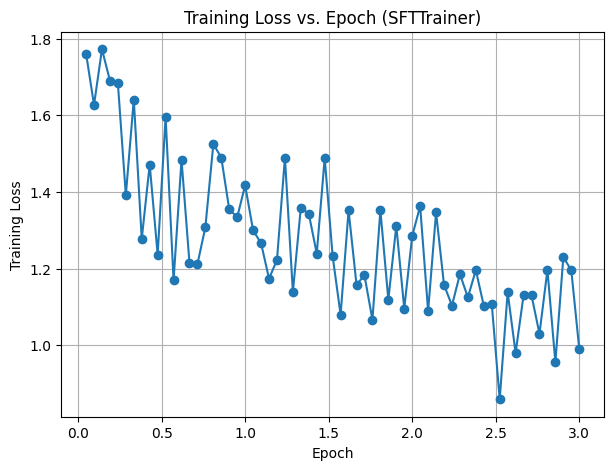

In [9]:
########################################
# After your training finishes, run this:
########################################
import matplotlib.pyplot as plt

# 'trainer.state.log_history' is a list of dictionaries. Each dictionary
# can contain 'loss', 'learning_rate', 'epoch', 'step', etc., at various points.
log_data = trainer.state.log_history

# We'll gather the epoch vs. loss from logs that contain both.
epochs = []
losses = []
for record in log_data:
    # Some records only have 'lr' or other info. We want those with 'epoch' & 'loss'.
    if 'epoch' in record and 'loss' in record:
        epochs.append(record['epoch'])
        losses.append(record['loss'])

# Now let's plot
plt.figure(figsize=(7,5))
plt.plot(epochs, losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epoch (SFTTrainer)")
plt.grid(True)
plt.show()
